# Preprocessing

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import heapq
import os
import sys
import numpy as np
import pandas as pd
# import tifffile as tif
# import h5py
from skimage import io, img_as_float32
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from scipy import stats
from skimage.filters import threshold_yen
from skimage.segmentation import find_boundaries
# import IPython.display
# import PIL
%matplotlib inline
import os, sys
sys.path.append("../bardensr")
import bardensr
import bardensr.plotting
import DeCRISP as dcp

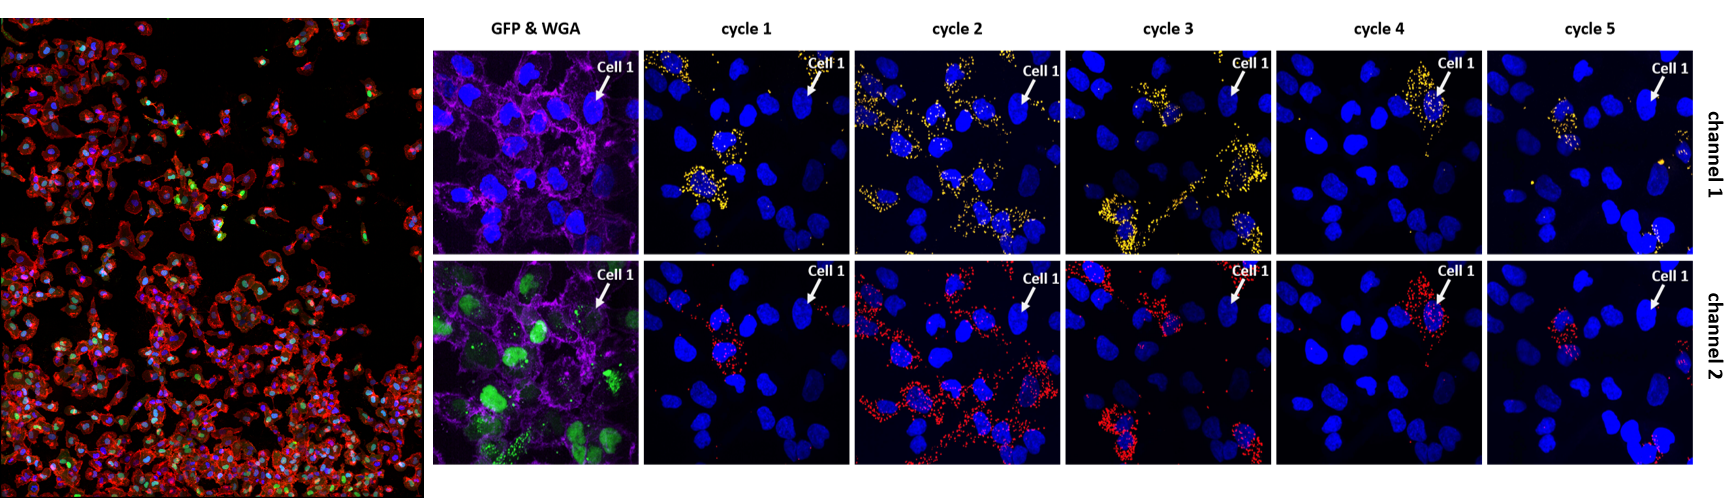

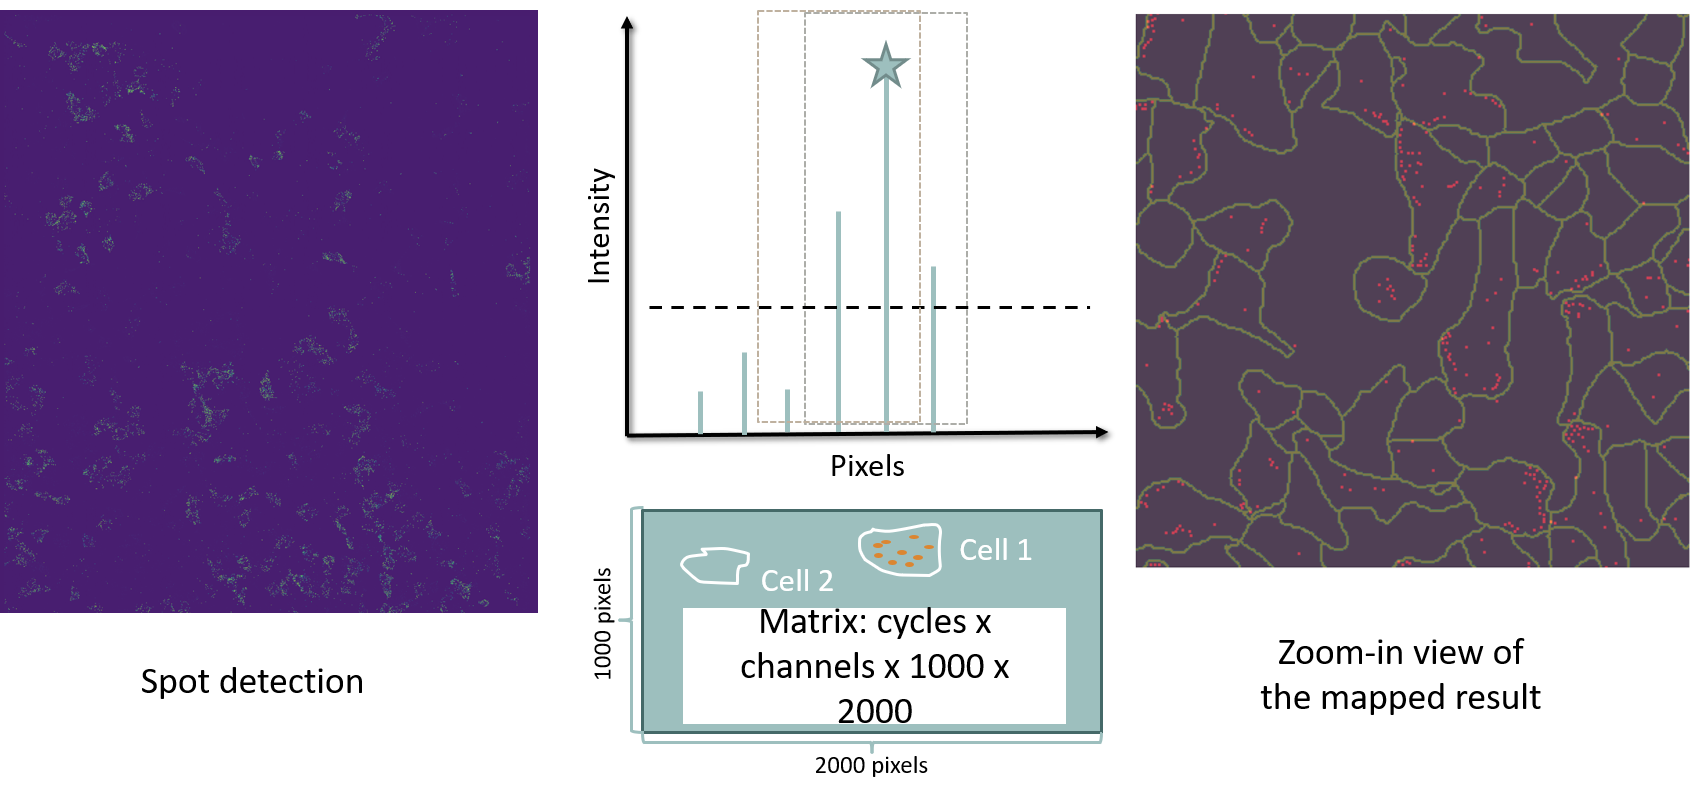

In [ ]:
n_channels = 2
n_cycles = 5

In [ ]:
with open('./data/registered20210714_sg2NEB.npy', 'rb') as f:
    X = np.load(f)

In [ ]:
X.shape

(10, 1, 2048, 1280)

In [ ]:
# for i in range(X.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(X[i, 0,])

## Check how many pixels are roughly in one amplicon

In [ ]:
# img = tif.imread('./data/crisprmap20210506/amp-ch1-cycle2.tiff')
# plt.figure(dpi=100)
# plt.imshow(img[80:100, 80:100, 1])
# plt.axis('image')
# # im.view()

This shows if the windows for local maxima is 3 by 3 pixels, they should be right for catching one amplicon

## Remove border artifact and get X only within the range of the slide - segmentation images must be set to the same range when overlaying

In [ ]:
up = 0
down = 1800
left = 10
right = 1150

Xcenter = X[:, :, up:down, left:right] # range is selected based on observation of images

In [ ]:
# for i in range(Xcenter.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(Xcenter[i, 0,])

# Codebook

The most important is to make sure the codebook and the images are of the same order

In [ ]:
codebook = pd.read_csv('./data/CRISPRmap_pilot_codebook_default.csv', dtype=np.int, header=None)
codebook = np.array(codebook)
codebook

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [ ]:
# codebook = csv.reshape((10, 2, 5)).T.astype(bool)
# codebook

In [ ]:
codebook.shape

(10, 10)

The order of the codebook matches the order of the image stack.

## Background subtraction and normalization

In [ ]:
Xcenter.shape

(10, 1, 1800, 1140)

In [ ]:
# Different from how bardensr did it (use these functions for now because they are tested)
Xnorm = bardensr.preprocessing.background_subtraction(Xcenter, [0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

In [ ]:
Xnorm.shape

(10, 1, 1800, 1140)

In [ ]:
# for i in range(Xnorm.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(Xnorm[i, 0,])

## Thresholding

In [ ]:
Xnorm.shape

(10, 1, 1800, 1140)

In [ ]:
Xnorm[0, 0,].shape

(1800, 1140)

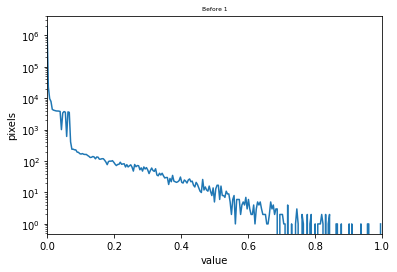

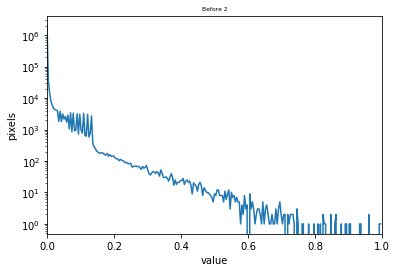

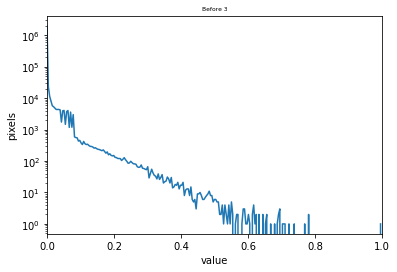

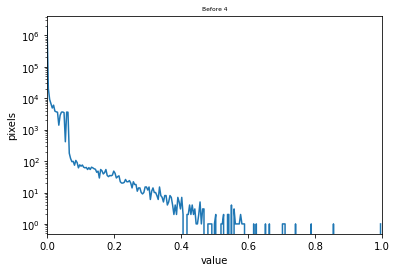

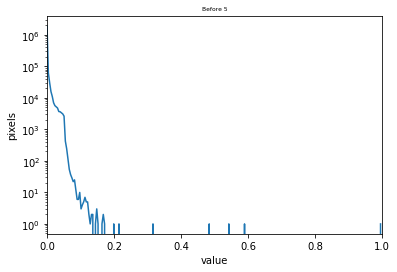

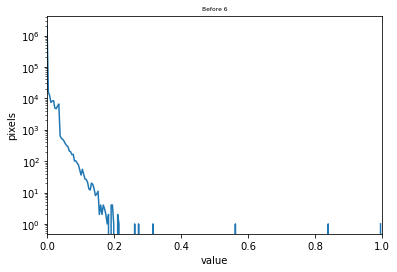

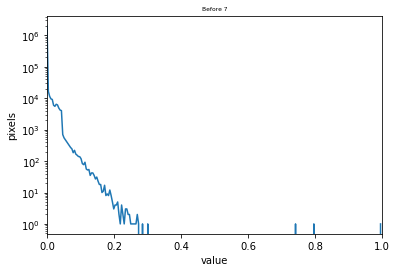

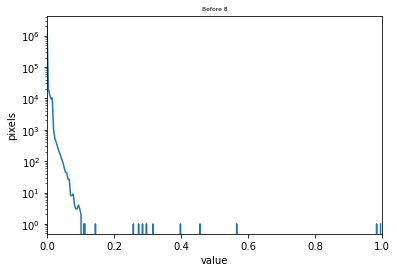

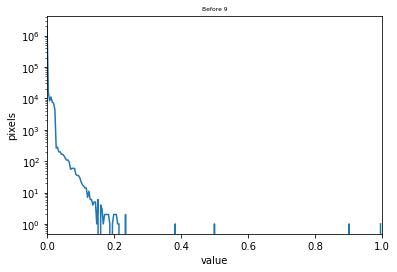

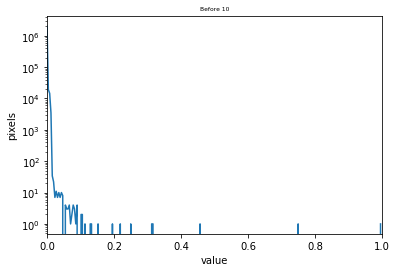

In [ ]:
# Before
for i in range(Xnorm.shape[0]):
    histogram, bin_edges = np.histogram(Xnorm[i, 0, ], bins=256, range=(0, 1))

    # configure and draw the histogram figure
    plt.figure()
    plt.title(f"Before {i+1}", fontsize=6)
    plt.xlabel("value")
    plt.ylabel("pixels")

    plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

    plt.xlim([0.0, 1.0])  # <- named arguments do not work here
    plt.show()

In [ ]:
Xnorm.shape[2:4]

(1800, 1140)

In [ ]:
upper = np.zeros(n_channels * n_cycles)
n_pixels = np.prod(Xnorm.shape[2:4])  # Xnorm.shape[2, 4] is the dimension of the 2D image
for i in range(Xnorm.shape[0]):
    hist, edges = np.histogram(Xnorm[i, 0].ravel(), bins=256, range=(0, 1))
    z = np.cumsum(hist)
    dz = np.diff(z)
    idx = np.array(np.where(dz >=3)).ravel()[-1]  # 3 set a param here
    upper[i] = edges[idx]

In [ ]:
upper

array([0.7421875 , 0.7421875 , 0.69140625, 0.5546875 , 0.14453125,
       0.19140625, 0.234375  , 0.09375   , 0.16015625, 0.0859375 ])

In [ ]:
np.array(np.where(dz >=3)).ravel()[-1]

22

In [ ]:
dz.shape

(255,)

In [ ]:
# upper = [0.9, 0.9, 0.8, 0.6, 0.14, 0.2, 0.3, 0.1, 0.2, 0.015]
# lower = [0.2, 0.16, 0.13, 0.15, 0.16, 0.16, 0.16, 0.13, 0.15, 0.15]
Xthresh = Xnorm.copy()
for i in range(Xthresh.shape[0]):
    single = Xthresh[i, 0,]
#     single[single < lower[i]] = 0
    single[single > upper[i]] = upper[i]
    Xthresh[i, 0] = single

Xthresh = bardensr.preprocessing.minmax(Xthresh)

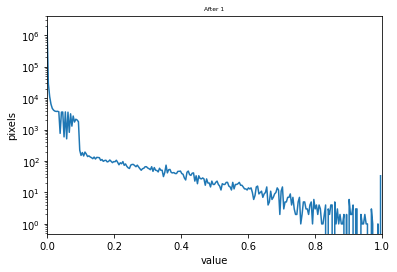

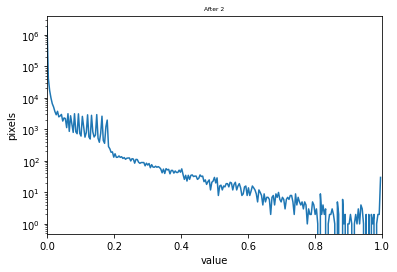

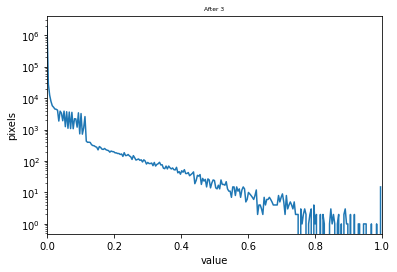

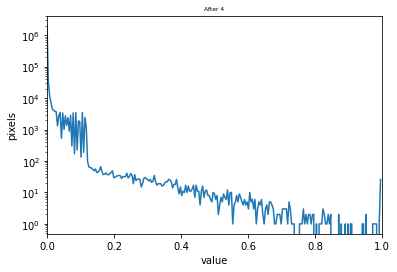

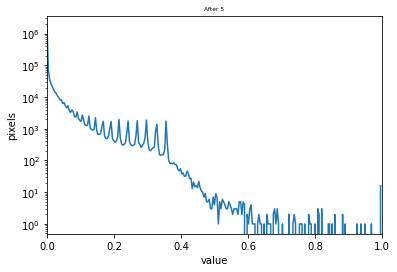

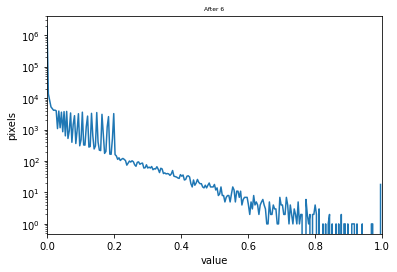

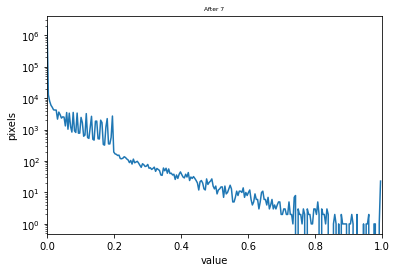

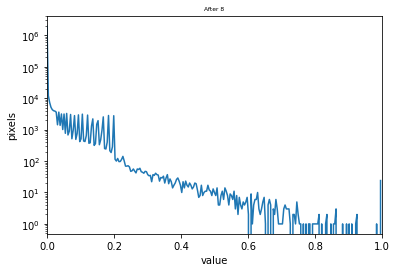

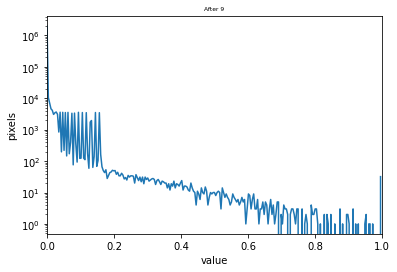

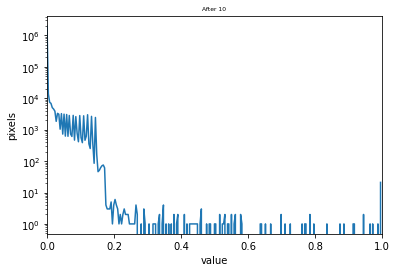

In [ ]:
# After
for i in range(Xthresh.shape[0]):
    histogram, bin_edges = np.histogram(Xthresh[i, 0, ], bins=256, range=(0, 1))

    # configure and draw the histogram figure
    plt.figure()
    plt.title(f"After {i+1}", fontsize=6)
    plt.xlabel("value")
    plt.ylabel("pixels")

    plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

    plt.xlim([0.0, 1.0])  # <- named arguments do not work here
    plt.show()

# Peak calling and counting (inside membrane masks)

**Check by overlay to see if there are enough spots called.**

In [ ]:
cell_table = create_celltable(Xthresh, masks_mem, n_std=6, up_adjust=up, left_adjust=left)
cell_table

In [ ]:
coords[:10]

[(0.0, 67.66666666666667, 560.6666666666666),
 (0.0, 144.0, 390.0),
 (0.0, 204.5, 725.5),
 (0.0, 228.0, 682.0),
 (0.0, 246.0, 766.0),
 (0.0, 279.5, 1129.0),
 (0.0, 294.5, 752.0),
 (0.0, 294.0, 890.5),
 (0.0, 339.0, 430.0),
 (0.0, 359.0, 363.5)]

In [ ]:
int(np.round(801.5228444869555))

802

In [ ]:
len(coords)

66

In [ ]:
np.max(cell_table)

125.0

In [ ]:
pd.DataFrame(cell_table)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,5.0,7.0,1.0,0.0,1.0,6.0,9.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
4,2.0,1.0,28.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# pd.DataFrame(cell_table).to_csv('./result/crisprmap20210714sg2NEB_cell_table.csv')

In [ ]:
cell_table.shape

(336, 10)

# Cross Correlation

In [ ]:
# Calculate the correlation
cell_norm = np.sqrt(np.sum(np.power(cell_table, 2), axis=1))
cell_corr = cell_table.dot(codebook.T) / np.reshape(cell_norm + 1e-6, (-1,1))  # add 1e-6 to avoid the denominator being 0

In [ ]:
cell_corr

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.999999  ,
        0.        ],
       [0.14359162, 0.07179581, 0.78975392, ..., 0.50257067, 0.93334554,
        1.00514135],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
cell_corr.shape

(336, 10)

In [ ]:
# Assign cells to barcodes according to the max correlation
# cell_id = pd.DataFrame(np.argmax(cell_corr, axis=1), columns=['barcode'])
corr_thresh = 0.01
cell_id = pd.DataFrame(argmax_thresh(cell_corr, axis=1, thresh=corr_thresh), columns=['barcode'])
cell_id

,barcode
0,-1
1,4
2,4
3,0
4,6
...,...
331,-1
332,-1
333,-1
334,-1


<!-- list1 = [10, 20, 4, 45, 99]

# new_list is a set of list1
new_list = set(list1)

# removing the largest element from temp list
new_list.remove(max(new_list))

# elements in original list are not changed
# print(list1)

print(max(new_list)) -->